In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode
import scipy

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

18.453333333333333
minima =  [ 1551  3392  5237  7082  8928 10773 12618 14464 16309 18155 20000 21845
 23691 25536 27381 29227 31072 32917 34763 36608 38453 40299 42144 43989
 45835 47680 49525]


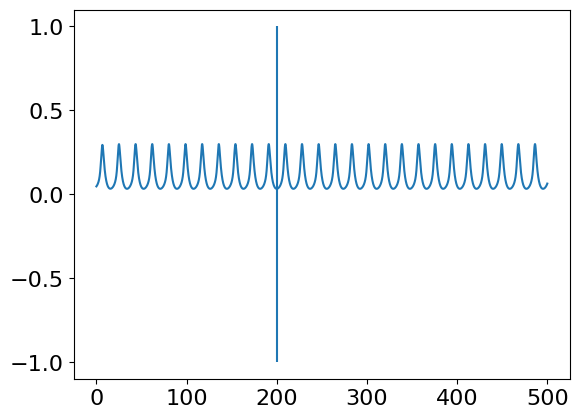

In [3]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.01
wc.params.dt = dt

duration = 500.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()
peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
p_list = []
for i in range(3,len(peaks)):
    p_list.append(peaks[i]- peaks[i-1])
period = np.mean(p_list)*dt

print(period)

init_min = [wc.exc[0,413], wc.inh[0,413]]
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])
wc.run()
target_min = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

mins = scipy.signal.find_peaks(-wc.exc[0,:])[0]
print("minima = ", mins)

plt.plot(wc.t, wc.exc[0,:])
plt.vlines(200,-1,1)
plt.show()

In [4]:
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

int0, int1 = 20000, None

duration = 300.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

In [6]:
def increase_step_compute():
    wc_controlled.step = 1e-2
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e-1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e0
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(400)
    
    wc_controlled.step = 1e1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(1000)

    return

def get_values(results_dict, iw, ish, w1):
    results_dict["control"][iw][ish] = wc_controlled.control.copy()
    results_dict["state"][iw][ish] = wc_controlled.get_xs().copy()
    results_dict["total_cost"][iw][ish] = wc_controlled.cost_history[-1]

    wc_controlled.w_1D = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][iw][ish] = wc_controlled.compute_total_cost()
    results_dict["L1_cost_weighted"][iw][ish] = ( results_dict["total_cost"][iw][ish] - results_dict["precision_cost"][iw][ish]) 
    results_dict["L1_cost_unweighted"][iw][ish] = results_dict["L1_cost_weighted"][iw][ish] / w1
    wc_controlled.w_1D = w1

    return

def get_period_index_target(period, i_sh, n_points, target_in):
    p = i_sh* 2.* np.pi / (n_points-1)
    index = np.round(p * period/ ( 2. * np.pi)/ dt).astype(int)
    target = target_in[:,:,index:index+np.round(1+duration/dt,1).astype(int)]

    return p, index, target

def getmodel(target_shift, w1, results_dict, iw, ish):
    wc_controlled = oc_wc.OcWc(wc, target=target_shift, w_p=1, w_2=0., w_1D=w1, print_array=[], precision_cost_interval=(int0,int1), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][iw][ish]) != type(None):
        wc_controlled.control = results_dict["control"][iw][ish].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled

In [7]:
n_points = 41
w_array = [1., 1.]
none_array = [[None] * n_points, [None] * n_points ]
file_array = ["e_w1.png", "i_w1.png", "4_min_w1.png"]

results_min = dict([
    ('w1', w_array),
    ("total_cost", [[None] * n_points, [None] * n_points]),
    ("initial_cost", [[None] * n_points, [None] * n_points ]),
    ("precision_cost", [[None] * n_points, [None] * n_points ]),
    ("L1_cost_unweighted", [[None] * n_points, [None] * n_points ]),
    ("L1_cost_weighted", [[None] * n_points, [None] * n_points]),
    ("control", [[None] * n_points, [None] * n_points]),
    ("control_init", [[None] * n_points, [None] * n_points]),
    ("state", [[None] * n_points, [None] * n_points ]),
    ("filename", file_array)
    ])

In [8]:
def save(results_dict):
    filehandler = open("a_s2_l1_pulsetrain.pickle","wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

def read():
    filehandler = open("a_s2_l1_pulsetrain.pickle","rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

def readfile(file):
    filehandler = open(file,"rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

In [ ]:
results_min = read()


In [53]:
amp = np.zeros((2))
amp[0] = 0.254
amp[1] = 0.276335

halfwidth = 30

target period =  17.56666666666667
zero control
Compute control for a deterministic system
Cost in iteration 0: 1.6970468232977547
Final cost : 1.6970468232977547
Compute control for a deterministic system
Cost in iteration 0: 0.6580219027058342
Final cost : 0.6580219027058342


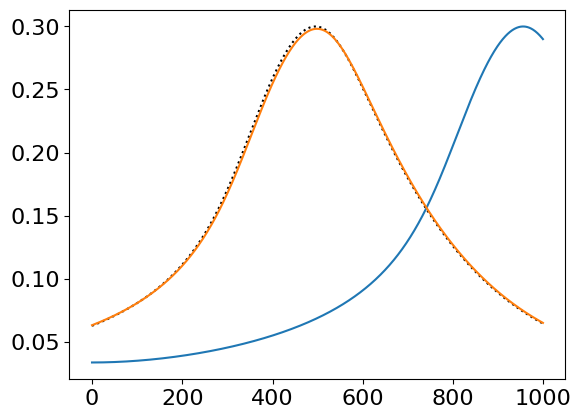

precision cost =  6.874327881389003e-05
Compute control for a deterministic system
Cost in iteration 0: 0.6580219027058342
Final cost : 0.4748773617666166
Compute control for a deterministic system
Cost in iteration 0: 0.4748773617666166
Final cost : 0.13742449881470264
Compute control for a deterministic system
Cost in iteration 0: 0.13742449881470264
Converged in iteration 55 with cost 0.1371941514202325 because of vanishing difference
Final cost : 0.1371941514202325
Compute control for a deterministic system
Cost in iteration 0: 0.1371941514202325
Final cost : 0.13715715730134057
Compute control for a deterministic system
Cost in iteration 0: 0.13715715730134057
Converged in iteration 207 with cost 0.1371571572615608 because of step counter
Final cost : 0.1371571572615608
target period =  17.56666666666667
zero control
Compute control for a deterministic system
Cost in iteration 0: 1.6970468232977547
Final cost : 1.6970468232977547
Compute control for a deterministic system
Cost in 

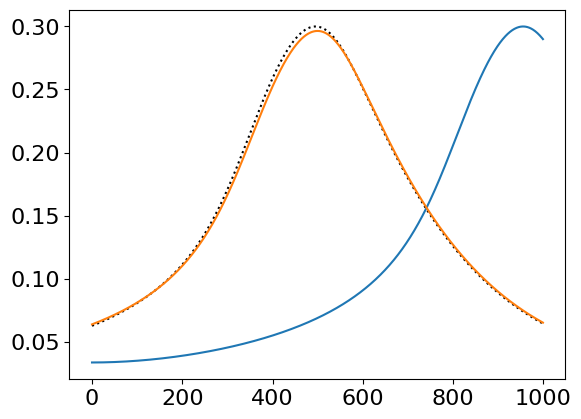

precision cost =  0.0001367363449451153
Compute control for a deterministic system
Cost in iteration 0: 0.7159457375664704
Final cost : 0.6646006050244333
Compute control for a deterministic system
Cost in iteration 0: 0.6646006050244333
Final cost : 0.32588380321140054
Compute control for a deterministic system
Cost in iteration 0: 0.32588380321140054
Final cost : 0.13724774157218453
Compute control for a deterministic system
Cost in iteration 0: 0.13724774157218453
Converged in iteration 38 with cost 0.1371856577082492 because of vanishing difference
Final cost : 0.1371856577082492
Compute control for a deterministic system
Cost in iteration 0: 0.1371856577082492
Converged in iteration 645 with cost 0.1371575458389118 because of step counter
Final cost : 0.1371575458389118


In [55]:
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])

ind_list = [10]
options = [False, False, False, False]

for k in range(1):

    for i_w in range(len(results_min["w1"])):

        w1 = results_min['w1'][i_w]

        for i_shift in range(n_points):

            if i_shift not in ind_list:
                continue

            period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)

            pulsetrain_e = np.zeros((target_shift.shape))

            peaks = scipy.signal.find_peaks(wc.exc[0,:20000])[0]
            #print(peaks)

            targetperiod = dt * ( peaks[-1] - peaks[0] ) / ( len(peaks) - 0.5)
            print("target period = ", targetperiod)

            if i_w == 0:
                indpulse = np.round(1.34834329 * targetperiod / (2.*dt)).astype(int)
                iinp = 0
            else:
                indpulse = np.round(1.8898968 * targetperiod / (2.*dt)).astype(int)
                iinp = 1
            #print("pulse = ", indpulse)

            indstart = peaks[0] + indpulse
            #print("start = ", indstart)

            for ip in range(len(peaks)):
                for t in np.arange(-halfwidth, halfwidth+1, 1):
                    pulsetrain_e[0,iinp,indstart + np.around(ip*targetperiod/dt).astype(int)+t] = amp[i_w]

            results_min["control_init"][i_w][i_shift] = pulsetrain_e


            """            
            plt.plot(pulsetrain_e[0,0,:])
            plt.show()  

            peaks_train = scipy.signal.find_peaks(pulsetrain_e[0,0,:])[0]
            for ip in range(1, len(peaks_train)):
                print(peaks_train[ip] - peaks_train[ip-1])

            """

            results_min["control"][i_w][i_shift] = None
            wc_controlled = getmodel(target_shift, w1, results_min, i_w, i_shift)

            print("zero control")
            wc_controlled.step = 1e-3
            wc_controlled.optimize(0)

            plt.plot(wc_controlled.model.exc[0,20000:21000])
            plt.plot(target_shift[0,0,20000:21000], color="black", linestyle=":")

            wc_controlled.control = pulsetrain_e.copy()
            wc_controlled.update_input()
            wc_controlled.model.run()    

            wc_controlled.step = 1e-3
            wc_controlled.optimize(0)

            plt.plot(wc_controlled.model.exc[0,20000:21000])
            plt.show()

            get_values(results_min, i_w, i_shift, w1)
            print("precision cost = ", results_min["precision_cost"][i_w][i_shift])

            wc_controlled.step = 1e-3
            wc_controlled.optimize(200)

            increase_step_compute()

            if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift]:
                get_values(results_min, i_w, i_shift, w1)
                
        save(results_min)

In [9]:
save(results_min)

# precision cost =  3.598035891197038e-05
# 0.00011455363542384309

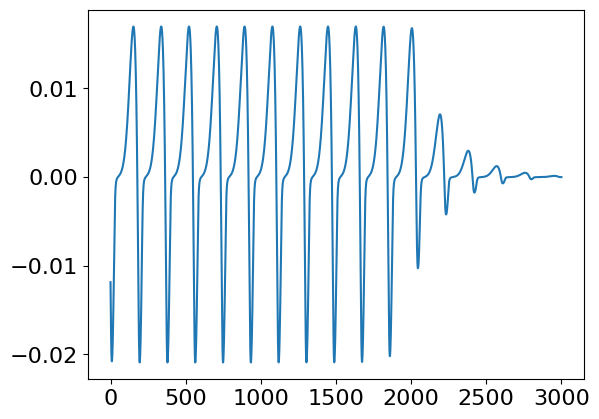

In [45]:
plt.plot(results_min["control"][1][10][0,0,:])
plt.show()